In [1]:
import nltk
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15403\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
tdf = pd.read_csv("train.csv")

In [3]:
tweet = pd.DataFrame(tdf)

In [4]:
tweet.drop(columns='keyword',inplace=True)

In [5]:
tweet.drop(columns='location',inplace = True)

In [6]:
tweets = [x for x in tweet['text']]

In [7]:
for tweets_no, tweets in enumerate(tweets[:10]):
    print(tweets_no, tweets)
    print('\n')

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


1 Forest fire near La Ronge Sask. Canada


2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


3 13,000 people receive #wildfires evacuation orders in California 


4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires


6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas


7 I'm on top of the hill and I can see a fire in the woods...


8 There's an emergency evacuation happening now in the building across the street


9 I'm afraid that the tornado is coming to our area...




In [8]:
tweet.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [9]:
tweet['length'] = tweet['text'].apply(len)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

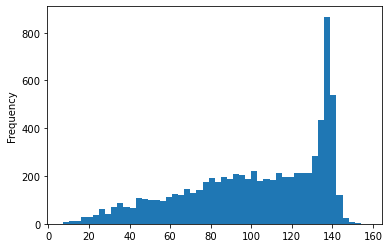

In [11]:
tweet['length'].plot(bins=50,kind='hist')

In [12]:
tweet.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

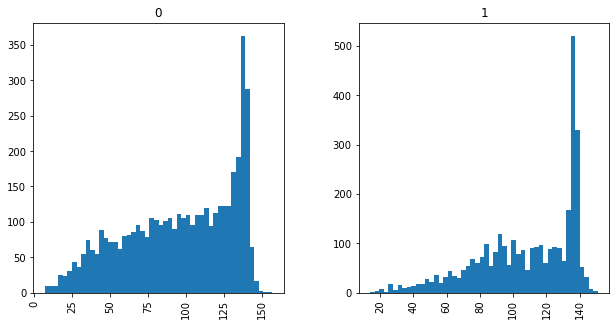

In [13]:
tweet.hist(column='length', by='target',bins=50,figsize=(10,5))

In [14]:
import string
from nltk.corpus import stopwords

In [15]:
def text_process(dirty):
    rempunc = [char for char in dirty if char not in string.punctuation]
    rempunc = ''.join(rempunc)
    return [word for word in rempunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
tweet['text'].head(5).apply(text_process)

0    [Deeds, Reason, earthquake, May, ALLAH, Forgiv...
1        [Forest, fire, near, La, Ronge, Sask, Canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, Ruby, Alaska, smoke, wildfi...
Name: text, dtype: object

In [17]:
tweet.head()

,id,text,target,length
0,1,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are ...,1,133
3,6,"13,000 people receive #wildfires evacuation or...",1,65
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(tweet['text'])
print(len(bow_transformer.vocabulary_))

26473


In [20]:
tweet4 = tweet['text'][3]
print(tweet4)

13,000 people receive #wildfires evacuation orders in California 


In [21]:
bow4 = bow_transformer.transform([tweet4])
print(bow4)
print(bow4.shape)

  (0, 144)	1
  (0, 2334)	1
  (0, 14502)	1
  (0, 22409)	1
  (0, 22635)	1
  (0, 23345)	1
  (0, 26071)	1
(1, 26473)


In [22]:
tweet_bow = bow_transformer.transform(tweet['text'])

In [23]:
print('Shape of Sparse Matrix: ', tweet_bow.shape)
print('Amount of Non-Zero occurences: ', tweet_bow.nnz)

Shape of Sparse Matrix:  (7613, 26473)
Amount of Non-Zero occurences:  75006


In [24]:
sparsity = (100.0 * tweet_bow.nnz / (tweet_bow.shape[0] * tweet_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(tweet_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 26071)	0.4024513325168046
  (0, 23345)	0.4718026141633829
  (0, 22635)	0.25921479580657425
  (0, 22409)	0.39780696282539063
  (0, 14502)	0.3391667965318131
  (0, 2334)	0.2781109881741682
  (0, 144)	0.44453648958637354


In [26]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['fire']])

4.850147601710058


In [27]:
tweet_tfidf = tfidf_transformer.transform(tweet_bow)
print(tweet_tfidf.shape)

(7613, 26473)


In [28]:
from sklearn.naive_bayes import MultinomialNB
accident_detect_model = MultinomialNB().fit(tweet_tfidf, tweet['target'])

In [29]:
print('predicted:', accident_detect_model.predict(tfidf4)[0])
print('expected:', tweet.target[23])

predicted: 1
expected: 0


In [30]:
all_predictions = accident_detect_model.predict(tweet_tfidf)
print(all_predictions)

[1 1 1 ... 1 1 1]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(tweet['target'],all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      4342
           1       0.97      0.83      0.89      3271

    accuracy                           0.91      7613
   macro avg       0.93      0.90      0.91      7613
weighted avg       0.92      0.91      0.91      7613



In [32]:
from sklearn.model_selection import train_test_split

twt_train, twt_test, target_train, target_test = \
train_test_split(tweet['text'], tweet['target'], test_size=0.2)

print(len(twt_train), len(twt_test), len(twt_train) + len(twt_test))

6090 1523 7613


In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [34]:
pipeline.fit(twt_train,target_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001B440D84E50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [35]:
predictions = pipeline.predict(twt_test)

In [36]:
print(classification_report(target_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       880
           1       0.83      0.68      0.75       643

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

